
# Практична робота №2 — Логістична регресія **з нуля** (Jupyter Notebook)

**Предмет:** Машинне навчання  
**Рівень:** 4 курс  
**Тема:** Побудова та дослідження моделі логістичної регресії для прогнозування результатів медичних тестів  
**Автор ноутбука:** *заповніть ПІБ*  
**Дата генерації:** 2025-09-17 18:22

---

### Що в цьому ноутбуці
1. Підготовка та аналіз даних (створення бінарної цілі, one-hot, нормалізація,EDA).
2. Розподіл на train/val/test (60/20/20).
3. Реалізація **логістичної регресії з нуля** (NumPy):  
   - сигмоїда, log-loss, градієнт,
   - **SGD** і **mini-batch GD**,
   - **L1/L2 регуляризація** (*інтерсепт не штрафується*),
   - **рання зупинка** та вибір кращих ваг.
4. **Криві навчання** (train/val loss по епохах).
5. Оцінка якості на test: **confusion matrix, accuracy, precision, recall, F1** (реалізовано вручну).
6. Порівняння SGD vs mini-batch у таблиці та висновки.

> **Важливо:** ноутбук не використовує готові реалізації LogisticRegression зі scikit-learn (дозволено лише допоміжні інструменти типу `train_test_split`, `get_dummies`).



## 0. Налаштування та завантаження датасету

- Скачайте датасет *Healthcare Dataset* з Kaggle і збережіть локально.  
- У змінній `DATA_PATH` нижче вкажіть шлях до CSV з даними (об’єднаний або той, де є стовпчик **`Test Results`**).  
- Якщо файл не знайдено, генератор створить **синтетичний датасет** зі схожими полями для демонстрації (лише для прикладу — не використовувати у звіті).


In [30]:

# !pip install pandas numpy matplotlib scikit-learn --quiet
import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Шлях до CSV з Kaggle
DATA_PATH = 'healthcare_dataset.csv'  # <-- ВКАЗАТИ ваш файл

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def make_synthetic_healthcare(n=2000, seed=RANDOM_STATE):
    rng = np.random.default_rng(seed)
    genders = ['Male','Female']
    blood_types = ['A','B','AB','O']
    conditions = ['Diabetes','Hypertension','Asthma','None']
    providers = ['Aetna','Blue Cross','Cigna','Medicare']
    adm_types = ['Emergency','Elective','Urgent']
    meds = ['Metformin','Lisinopril','Albuterol','None']

    df = pd.DataFrame({
        'Name': [f'Patient_{i:05d}' for i in range(n)],
        'Gender': rng.choice(genders, n),
        'Age': rng.normal(50, 15, n).clip(0, 100).round(0).astype(int),
        'Blood Type': rng.choice(blood_types, n),
        'Medical Condition': rng.choice(conditions, n, p=[0.25,0.25,0.15,0.35]),
        'Insurance Provider': rng.choice(providers, n),
        'Admission Type': rng.choice(adm_types, n, p=[0.2,0.6,0.2]),
        'Medication': rng.choice(meds, n, p=[0.3,0.3,0.2,0.2]),
        'Billing Amount': rng.normal(5000, 2000, n).clip(200, 30000),
        'Doctor': rng.choice(['Dr. A','Dr. B','Dr. C'], n),
        'Hospital': rng.choice(['Hosp1','Hosp2','Hosp3'], n),
        'Room Number': rng.integers(100, 999, n),
        'Date of Admission': pd.to_datetime('2023-01-01') + pd.to_timedelta(rng.integers(0, 365, n), unit='D'),
        'Discharge Date': pd.NaT,
    })
    # Груба залежність: Normal якщо молодший, без хроніки, менший біллінг
    z = (
        -0.04*(df['Age']-50)
        -0.6*(df['Medical Condition'].isin(['Diabetes','Hypertension']).astype(int))
        -0.3*(df['Admission Type'].eq('Emergency').astype(int))
        -0.0002*(df['Billing Amount']-5000)
        + rng.normal(0, 0.5, n)
    )
    p = 1/(1+np.exp(-z))
    df['Test Results'] = np.where(p>0.5, 'Normal', 'Abnormal')
    return df

# Завантаження або синтетика
if os.path.exists(DATA_PATH):
    df_raw = pd.read_csv(DATA_PATH)
    print(f'[OK] Loaded dataset from {DATA_PATH} with shape {df_raw.shape}')
else:
    print('[WARN] File not found. Generating synthetic dataset for demo...')
    df_raw = make_synthetic_healthcare(n=2000)
    print('[OK] Synthetic dataset ready:', df_raw.shape)

df_raw.head()


[OK] Loaded dataset from healthcare_dataset.csv with shape (55500, 15)


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal



## 1. Підготовка даних та аналіз

- Створимо бінарну ціль `Test_Result_Normal` (1 якщо `Test Results == "Normal"`, інакше 0).  
- Видалимо неінформативні колонки.  
- One-hot для категоріальних ознак.  
- Нормалізація числових ознак (стандартизація до нульового середнього й одиничного відхилення).  
- Перевіримо розподіл цілі, кореляції та гістограми числових ознак.


In [31]:

# Конфіг полів
TARGET_COL = 'Test Results'
DROP_COLS = ['Name','Date of Admission','Doctor','Hospital','Room Number','Discharge Date']

# Обов'язкові числові
NUM_COLS = ['Age','Billing Amount']

# Спроба знайти потрібні колонки автоматично
for c in DROP_COLS:
    if c not in df_raw.columns:
        # Якщо якесь поле відсутнє — ігноруємо
        pass
drop_cols = [c for c in DROP_COLS if c in df_raw.columns]

assert TARGET_COL in df_raw.columns, f"У датасеті немає стовпчика '{TARGET_COL}'"

df = df_raw.copy()

# Ціль
df['Test_Result_Normal'] = (df[TARGET_COL] == 'Normal').astype(int)

# Видаляємо неінформативні
df = df.drop(columns=drop_cols, errors='ignore')

# Розділимо на числові/категоріальні
num_cols = [c for c in NUM_COLS if c in df.columns]
cat_cols = [c for c in df.columns if c not in num_cols + [TARGET_COL, 'Test_Result_Normal'] and df[c].dtype == 'object']

# One-hot
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Нормалізація числових
for c in num_cols:
    mu, sigma = df[c].mean(), df[c].std(ddof=0) if df[c].std(ddof=0) > 0 else 1.0
    df[c] = (df[c] - mu) / sigma

# Фінальні X, y
X_all = df.drop(columns=[TARGET_COL, 'Test_Result_Normal'], errors='ignore').copy()
y_all = df['Test_Result_Normal'].values.reshape(-1, 1).astype(float)

print('Shapes:', X_all.shape, y_all.shape)
X_all.head()


Shapes: (55500, 25) (55500, 1)


,Age,Billing Amount,Gender_Male,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,Blood Type_B+,Blood Type_B-,Blood Type_O+,Blood Type_O-,...,Insurance Provider_Blue Cross,Insurance Provider_Cigna,Insurance Provider_Medicare,Insurance Provider_UnitedHealthcare,Admission Type_Emergency,Admission Type_Urgent,Medication_Ibuprofen,Medication_Lipitor,Medication_Paracetamol,Medication_Penicillin
0,-1.098824,-0.470261,True,False,False,False,False,True,False,False,...,True,False,False,False,False,True,False,False,True,False
1,0.533639,0.570250,True,False,False,False,False,False,False,False,...,False,False,True,False,True,False,True,False,False,False
2,1.247842,0.169990,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,-1.200853,0.870465,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
4,-0.435636,-0.795211,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True


Target distribution (0/1): {np.int64(0): np.int64(36983), np.int64(1): np.int64(18517)}


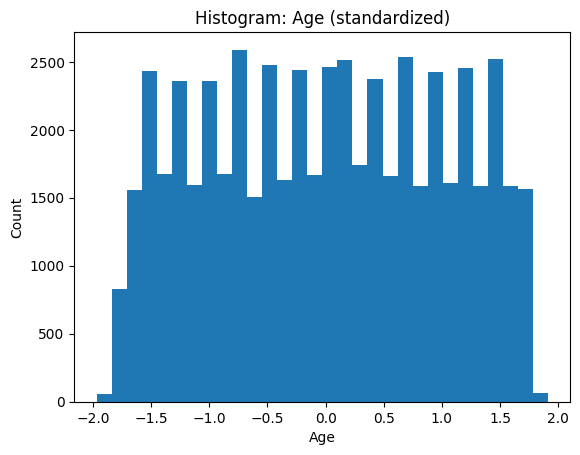

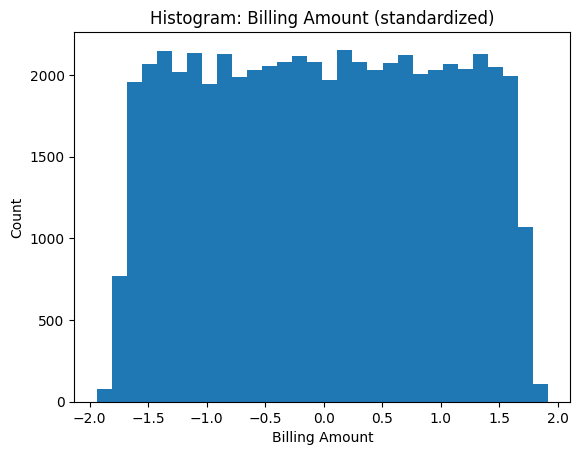

In [32]:

# EDA: розподіл цілі
vals, counts = np.unique(y_all, return_counts=True)
print('Target distribution (0/1):', dict(zip(vals.astype(int), counts)))

# Гістограми числових
for c in [col for col in X_all.columns if col in ['Age','Billing Amount']]:
    plt.figure()
    plt.hist(X_all[c].values, bins=30)
    plt.title(f'Histogram: {c} (standardized)')
    plt.xlabel(c)
    plt.ylabel('Count')
    plt.show()


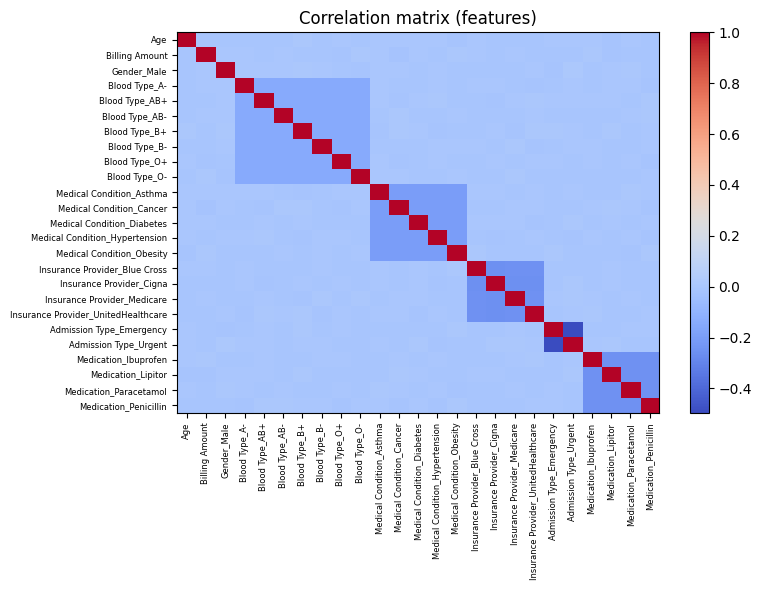

In [33]:

# Кореляційна матриця для всіх ознак
corr = X_all.corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Correlation matrix (features)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
plt.tight_layout()
plt.show()



## 2. Розподіл даних на Train / Validation / Test (60/20/20)


In [34]:

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all.values, y_all, test_size=0.20, random_state=RANDOM_STATE, stratify=y_all
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE, stratify=y_trainval
)  # 0.25 * 0.8 = 0.20

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

# Додаємо стовпець 1 для інтерсепта
def add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1), dtype=float), X.astype(float)])


X_train_i = add_intercept(X_train)
X_val_i   = add_intercept(X_val)
X_test_i  = add_intercept(X_test)
X_train_i.shape, X_val_i.shape, X_test_i.shape


Train: (33300, 25) Val: (11100, 25) Test: (11100, 25)


((33300, 26), (11100, 26), (11100, 26))


## 3. Логістична регресія з нуля (SGD / Mini-batch, L1/L2)

- Сигмоїда, log-loss з числовою стабілізацією.  
- Градієнт (векторизовано).  
- Підтримка L1/L2 (без штрафу для `w0` — інтерсепт).  
- Навчання: **SGD** (batch_size=1) або **mini-batch** (batch_size>1).  
- Рання зупинка та збереження найкращих ваг за мінімальним `val_loss`.


In [35]:

def sigmoid(z):
    z = np.asanyarray(z, dtype=float)
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))


def log_loss(y_true, y_prob, l1=0.0, l2=0.0, w=None):
    # y_true: (n,1), y_prob: (n,1)
    eps = 1e-12
    y_prob = np.clip(y_prob, eps, 1-eps)
    n = y_true.shape[0]
    loss = -np.mean(y_true*np.log(y_prob) + (1-y_true)*np.log(1-y_prob))
    if w is not None:
        # не штрафуємо інтерсепт
        w_no_bias = w[1:].reshape(-1,1)
        loss += l2 * 0.5 * np.sum(w_no_bias**2) / n
        loss += l1 * np.sum(np.abs(w_no_bias)) / n
    return loss

def predict_proba(X, w):
    return sigmoid(X @ w)

def compute_gradient(X, y, w, l1=0.0, l2=0.0):
    X = X.astype(float)
    y = y.astype(float)
    w = w.astype(float)

    n = X.shape[0]
    y_hat = predict_proba(X, w)
    grad = (X.T @ (y_hat - y)) / n

    if l2 > 0.0:
        reg = np.vstack([np.array([[0.0]]), l2 * w[1:]])
        grad += reg / n
    if l1 > 0.0:
        sign = np.sign(w)
        sign[0,0] = 0.0
        grad += (l1 * sign) / n

    return grad.astype(float)


def iterate_minibatches(X, y, batch_size=32, shuffle=True, seed=RANDOM_STATE):
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(idx)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_idx = idx[start:end]
        yield X[batch_idx], y[batch_idx]

def fit_logreg(
    X_train, y_train, X_val, y_val,
    lr=0.1, epochs=200, batch_size=1, # batch_size=1 -> SGD
    l1=0.0, l2=0.0,
    patience=10, seed=RANDOM_STATE
):
    d = X_train.shape[1]
    rng = np.random.default_rng(seed)
    w = rng.normal(0, 0.01, size=(d,1)).astype(float)

    best_w = w.copy()
    best_val = float('inf')
    bad_epochs = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        for Xb, yb in iterate_minibatches(X_train, y_train, batch_size=batch_size, shuffle=True, seed=seed+epoch):
            grad = compute_gradient(Xb, yb, w, l1=l1, l2=l2)
            w -= lr * grad

        # Моніторинг
        train_loss = log_loss(y_train, predict_proba(X_train, w), l1=l1, l2=l2, w=w)
        val_loss   = log_loss(y_val,   predict_proba(X_val,   w), l1=l1, l2=l2, w=w)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_w = w.copy()
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                # Рання зупинка
                break
    return best_w, np.array(train_losses), np.array(val_losses)



### 3.1 Навчання: SGD vs Mini-batch

Зафіксуємо гіперпараметри та запустимо два режими:
- **SGD:** `batch_size=1`
- **Mini-batch:** `batch_size=32` (можна змінювати)


In [36]:

params = dict(
    lr=0.1,
    epochs=300,
    patience=15,
    l1=0.0,
    l2=0.001 # легкий L2 для стабільності
)

w_sgd, tr_sgd, vl_sgd = fit_logreg(
    X_train_i, y_train, X_val_i, y_val,
    batch_size=1, **params
)

w_mb, tr_mb, vl_mb = fit_logreg(
    X_train_i, y_train, X_val_i, y_val,
    batch_size=32, **params
)

print('Best epochs (approx): SGD', len(vl_sgd), '| Mini-batch', len(vl_mb))


Best epochs (approx): SGD 27 | Mini-batch 37


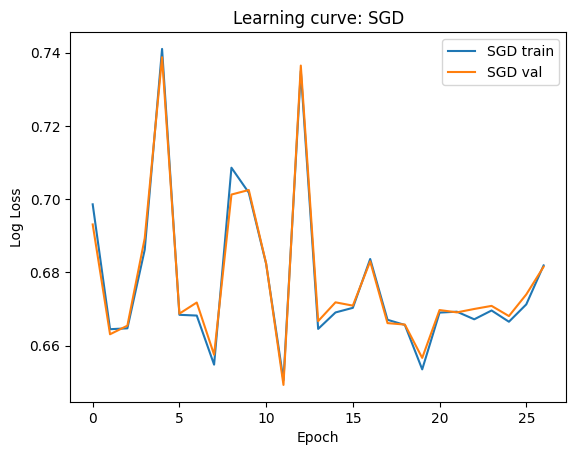

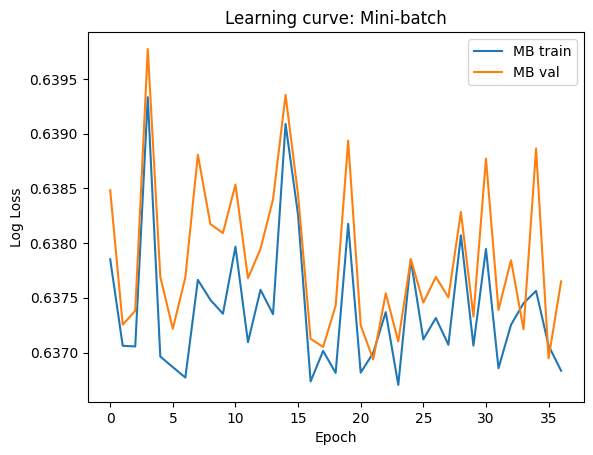

In [37]:

# Криві навчання
plt.figure()
plt.plot(tr_sgd, label='SGD train')
plt.plot(vl_sgd, label='SGD val')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Learning curve: SGD')
plt.legend()
plt.show()

plt.figure()
plt.plot(tr_mb, label='MB train')
plt.plot(vl_mb, label='MB val')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Learning curve: Mini-batch')
plt.legend()
plt.show()



## 4. Оцінка моделі (Confusion Matrix, Accuracy, Precision, Recall, F1)

Оберемо кращу модель за мінімальним `val_loss`, спрогнозуємо на `test` та порахуємо метрики **вручну**.


In [38]:

def predict_label(X, w, thr=0.5):
    return (predict_proba(X, w) >= thr).astype(int)

def confusion_matrix_binary(y_true, y_pred):
    # y_true/pred (n,1)
    y_true = y_true.astype(int).reshape(-1)
    y_pred = y_pred.astype(int).reshape(-1)
    tp = np.sum((y_true==1)&(y_pred==1))
    tn = np.sum((y_true==0)&(y_pred==0))
    fp = np.sum((y_true==0)&(y_pred==1))
    fn = np.sum((y_true==1)&(y_pred==0))
    return np.array([[tn, fp],
                     [fn, tp]])

def metrics_binary(cm):
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    acc = (tp+tn) / max(cm.sum(), 1)
    prec = tp / max(tp+fp, 1)
    rec = tp / max(tp+fn, 1)
    f1 = 2*prec*rec / max(prec+rec, 1e-12)
    return dict(accuracy=acc, precision=prec, recall=rec, f1=f1)

# Вибір кращої моделі
best_is_sgd = (vl_sgd.min() <= vl_mb.min())
w_best = w_sgd if best_is_sgd else w_mb
best_name = 'SGD' if best_is_sgd else 'Mini-batch'
print('Best by val_loss:', best_name)

# Оцінка
y_pred_test = predict_label(X_test_i, w_best, thr=0.5)
cm = confusion_matrix_binary(y_test, y_pred_test)
m = metrics_binary(cm)
cm, m


Best by val_loss: Mini-batch


(array([[7397,    0],
        [3703,    0]]),
 {'accuracy': np.float64(0.6663963963963964),
  'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0)})

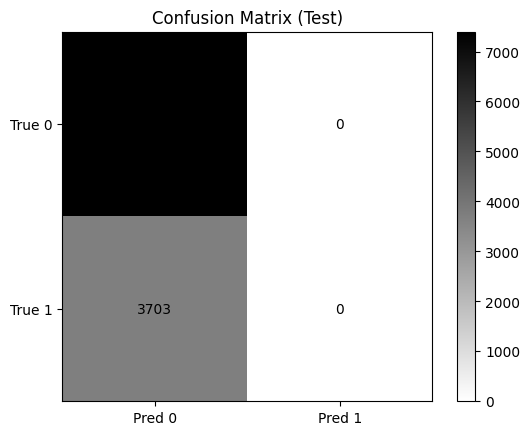

Metrics (Test):
accuracy: 0.6664
precision: 0.0000
recall: 0.0000
f1: 0.0000


In [39]:

# Візуалізація конфузіон-матриці
plt.figure()
plt.imshow(cm, cmap='gray_r')
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(cm[i,j]), ha='center', va='center')
plt.xticks([0,1], ['Pred 0','Pred 1'])
plt.yticks([0,1], ['True 0','True 1'])
plt.title('Confusion Matrix (Test)')
plt.colorbar()
plt.show()

print('Metrics (Test):')
for k,v in m.items():
    print(f'{k}: {v:.4f}')



## 5. Порівняння SGD vs Mini-batch

Зберемо метрики обох підходів у таблицю для порівняння.


In [40]:

def evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, batch_size, params, name):
    w, tr, vl = fit_logreg(X_train, y_train, X_val, y_val, batch_size=batch_size, **params)
    yhat = predict_label(X_test, w, 0.5)
    cm_ = confusion_matrix_binary(y_test, yhat)
    met = metrics_binary(cm_)
    return dict(name=name, best_epoch=len(vl), val_loss=float(vl.min()), **met)
 
res = []
res.append(evaluate_model(X_train_i, y_train, X_val_i, y_val, X_test_i, y_test, batch_size=1,  params=params, name='SGD'))
res.append(evaluate_model(X_train_i, y_train, X_val_i, y_val, X_test_i, y_test, batch_size=32, params=params, name='Mini-batch'))

df_compare = pd.DataFrame(res)
df_compare


,name,best_epoch,val_loss,accuracy,precision,recall,f1
0,SGD,27,0.649267,0.660450,0.3125,0.014853,0.028358
1,Mini-batch,37,0.636936,0.666396,0.0000,0.000000,0.000000



## 6. Висновки

- **Криві навчання**: прокоментуйте збіжність, стабільність, наявність/відсутність перенавчання.  
- **Порівняння**: який підхід (SGD чи mini-batch) показав кращий баланс швидкості та стабільності на ваших даних?  
- **Регуляризація**: як впливає збільшення `l2` або додавання `l1` (спробуйте інші значення в `params`)?  
- **Які помилки частіші** (FP чи FN) та чому це може бути важливим з медичної точки зору.
